In [1]:
import heapq
import os.path
import re
from glob import glob
from operator import itemgetter
from optparse import OptionParser
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from momentum_model import MomentumModel
from network import SimpleNet
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional
from visualize_orig import load_train_parameters
from dataset import normalize
import random
random.seed(42)
# %config InlineBackend.close_figures=False # keep figures open in pyplot


from dataset import UFData 

In [2]:
def random_blur(image, max_sigma=3, kernel_size=19):
        if image.ndim != 3:  
            image = image[None]
        blur_param = random.random() * max_sigma
        real = functional.gaussian_blur(image, kernel_size, blur_param)
#         imaginary = functional.gaussian_blur(image.imag, kernel_size, blur_param)
        return real #+ 1j * imaginary

def random_invert(image):
    if image.ndim != 3:
        image = image[None]
#     real, imaginary = image.real, image.imag
    real = functional.invert(image)
#     imaginary = functional.invert(imaginary)
    return real #+ 1j * imaginary   

def minmax_norm(img):
    return (img-img.min())/(img.max()-img.min())

def random_crop(image, offset=None):
    cropped_image_size = np.array([640, 320]) - (434, 50)
    if offset is None:
        # +1 since random doesn't include max. i.e [a, b).
        offset = np.random.randint(0, image.shape[1:] - cropped_image_size + 1)
    stop = offset + cropped_image_size
    return image[:, offset[0]:stop[0], offset[1]:stop[1]], offset

In [3]:
class Arg():
    def __init__(self):
        self.logdir = "/mikQNAP/anacis/ufloss_checkpoints/12_17_22/curveaug_mag_temp07_norm99_lr1e-3/1" # result with 1s
#         self.logdir = '/mikQNAP/anacis/ufloss_checkpoints/11_10_22/jitterinvertblur_mag_temp07_norm99_lr1e-3/1'
        self.datadir = "/mikQNAP/NYU_knee_data/knee_train_h5/data/train"
        self.t1t2dir = "/mikBIG/kewang/DCSNet_data_volunteer/Train"
        self.use_magnitude = True
        self.norm = 0.99
        self.fastmri = True
        self.gpu_id = 3
        self.checkpoint = None
        self.temperature = 0.7
args = Arg()

In [4]:
#Load model
torch.backends.cudnn.benchmark = True
params_dir = os.path.join(args.logdir, "params")
params_paths = sorted(glob(os.path.join(params_dir, "params_*")))
if len(params_paths) > 0:
    print("Existing Arguments")
    args = load_train_parameters(args)

print(f"Existing Args: {args}")

device = torch.device(f'cuda:{args.gpu_id}' if args.gpu_id is not None else 'cpu')

print(os.path.join(args.logdir, 'checkpoints/*'))
checkpoint = sorted(glob(os.path.join(args.logdir, 'checkpoints/*')),
                    key=lambda x: int(re.match(".*[a-z]+(\d+).pth", x).group(1)))[-1]

checkpoint_number = re.match(".*[a-z]+(\d+).pth", checkpoint).group(1)
ksnet = MomentumModel(SimpleNet, magnitude=args.use_magnitude, temperature=args.temperature)

print(f"Loading checkpoint from: {checkpoint}")
# Loading on cpu before transferring to model
ksnet.load_state_dict(torch.load(checkpoint, "cpu")["state_dict"])

ksnet = ksnet.target_network
ksnet.to(device)
ksnet.eval()

save_dir = os.path.join(args.logdir, "results")
os.makedirs(save_dir, exist_ok=True)

Existing Arguments
Existing Args: Namespace(batchsize=32, branch='voxelmorph', checkpoint=None, commit_hash='22c9367d9f24a1e935ee54441ba57a0070a1a2bb', datadir='/mikQNAP/NYU_knee_data/knee_train_h5/data/train', date_time='12-07-2022_11-44-23', epochs=200, fastmri=True, features=128, force_train_from_scratch=True, gpu_id=3, learning_rate=0.001, logdir='/mikQNAP/anacis/ufloss_checkpoints/12_17_22/curveaug_mag_temp07_norm99_lr1e-3/1', momentum=0.999, norm=0.99, start_epoch=1, t1t2dir='/mikBIG/kewang/DCSNet_data_volunteer/Train', temperature=0.7, use_magnitude=True)
/mikQNAP/anacis/ufloss_checkpoints/12_17_22/curveaug_mag_temp07_norm99_lr1e-3/1/checkpoints/*
Using parameters:
   Momentum: 0.99975
   Temperature: 0.7
mag True
Loading checkpoint from: /mikQNAP/anacis/ufloss_checkpoints/12_17_22/curveaug_mag_temp07_norm99_lr1e-3/1/checkpoints/ckpt200.pth


In [20]:
def get_shifted_patches(im, center):
    x = random.randint(-10, 10)
    y = random.randint(-10, 10)
    
    shifted_x = im[center[0] - 47//2 + x:center[0] + 47//2+1 + x, center[1] - 47//2:center[1] + 47//2+1]     
    shifted_x = minmax_norm(np.abs(shifted_x).float())
    shifted_x = shifted_x[None][None]
    
    shifted_y = im[center[0] - 47//2:center[0] + 47//2+1, center[1] - 47//2+y:center[1] + 47//2+1+y]     
    shifted_y = minmax_norm(np.abs(shifted_y).float())
    shifted_y = shifted_y[None][None]
    
    shifted_xy = im[center[0] - 47//2 + x:center[0] + 47//2+1 + x, center[1] - 47//2+y:center[1] + 47//2+1+y]     
    shifted_xy = minmax_norm(np.abs(shifted_xy).float())
    shifted_xy = shifted_xy[None][None]
    
    return [shifted_x, shifted_y, shifted_xy, x, y]
    

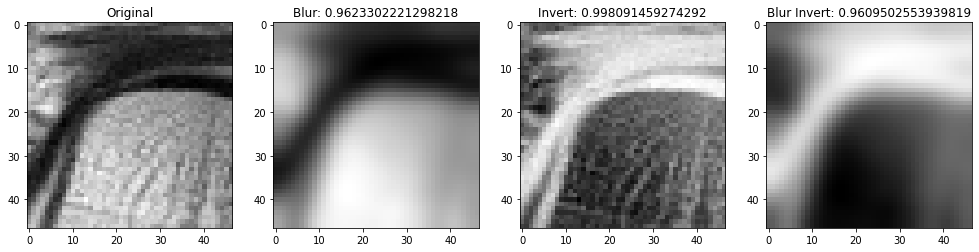

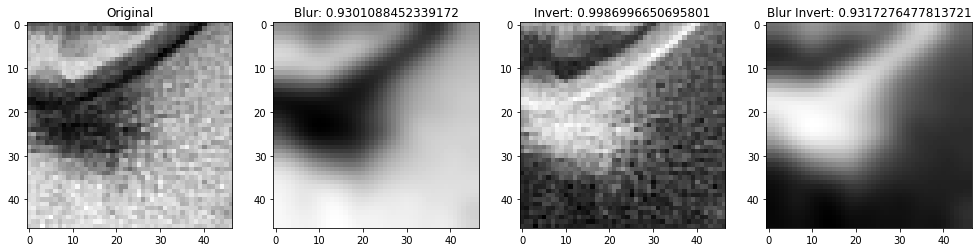

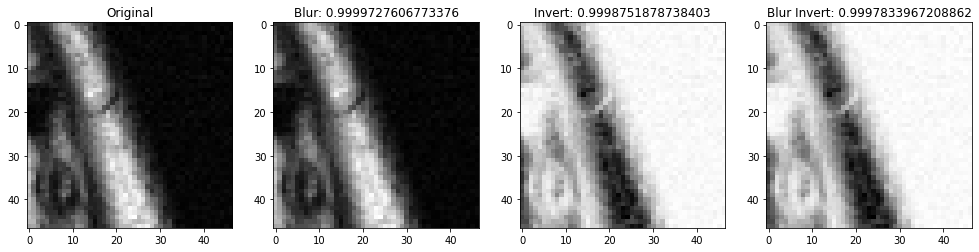

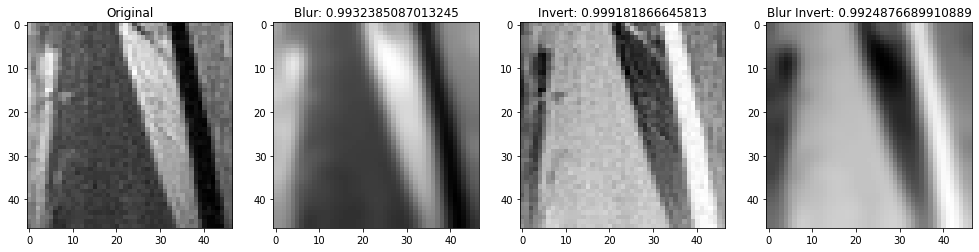

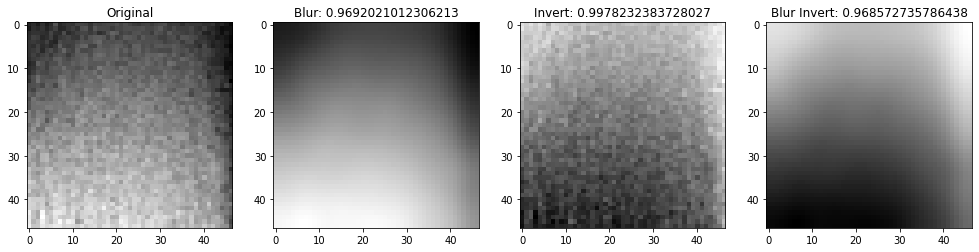

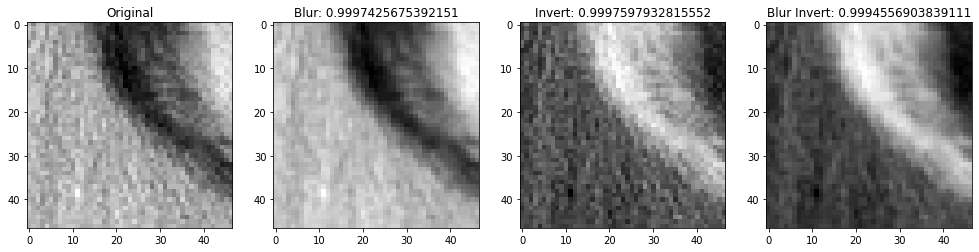

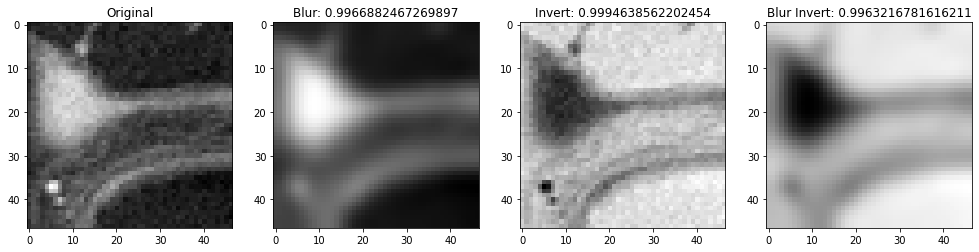

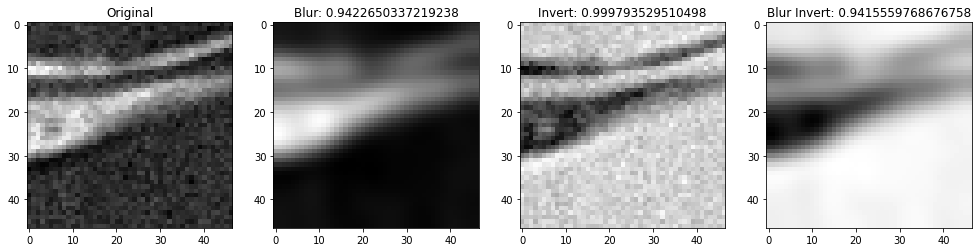

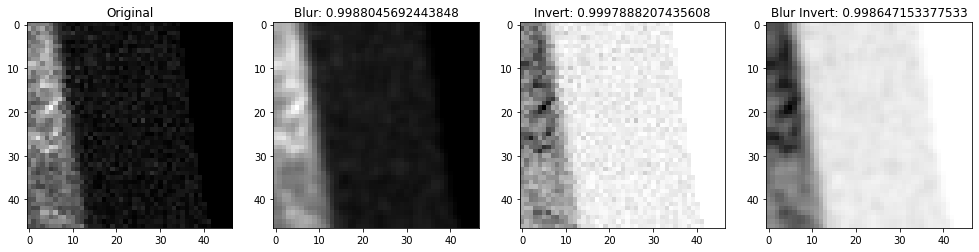

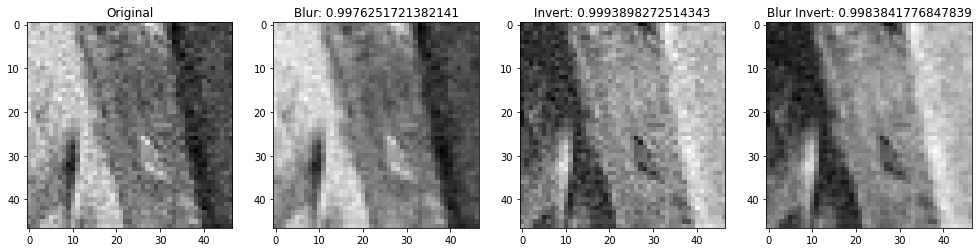

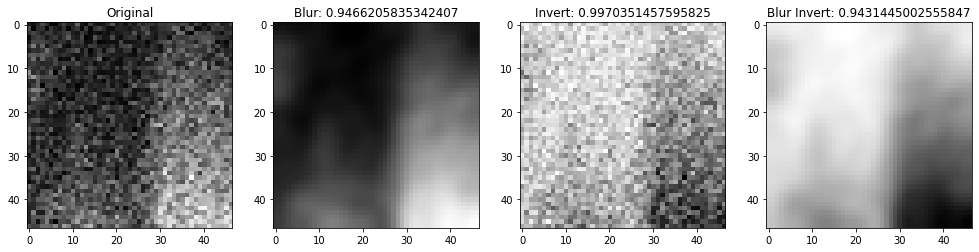

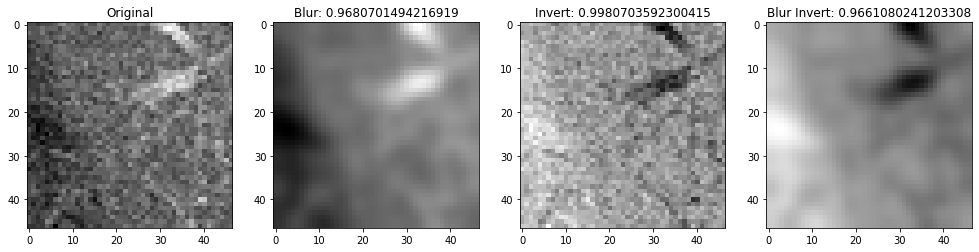

In [21]:
input_paths = [
            "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1000153_4.npy",
            "/home/asdegoyeneche/UFLoss/fastmri_val_images/file1001059_2.npy",
        ]
patch_centers = [(300, 120), (310, 200), (280, 290),
                         (450, 120), (95, 180), (200, 220)]



patches = []
patch_embs = []
shifted_patches = []

#Comparison of patch against augmentations

for path in input_paths:
    im = np.load(path)
    im = torch.from_numpy(im)
    for center in patch_centers:
        #data preprocessing
        patch = im[center[0] - 47//2:center[0] + 47//2+1, center[1] - 47//2:center[1] + 47//2+1]     
        patch = minmax_norm(np.abs(patch).float())
        
        
        blur_im = random_blur(patch)
        invert_im = random_invert(patch)[None]
        blur_invert_im = random_invert(blur_im)[None]
        
        patch = patch[None][None]
        blur_im = blur_im[None]
        
        patch = normalize(patch)
        blur_im = normalize(blur_im)
        invert_im = normalize(invert_im)
        blur_invert_im = normalize(blur_invert_im)
                
        #calculate embedding scores
        patch_emb = ksnet(patch.to(device))[0]
        blur_emb = ksnet(blur_im.to(device))[0]
        invert_emb = ksnet(invert_im.to(device))[0]
        blur_invert_emb = ksnet(blur_invert_im.to(device))[0]
        
        blur_score = torch.sum(patch_emb * blur_emb, dim=1).detach().cpu().mean()
        invert_score = torch.sum(patch_emb * invert_emb, dim=1).detach().cpu().mean()
        blur_invert_score = torch.sum(patch_emb * blur_invert_emb, dim=1).detach().cpu().mean()
        
        patches.append(patch)
        patch_embs.append(patch_emb)
        shifted_patches.append(get_shifted_patches(im, center))
        
        
        plt.figure(figsize=(15, 15))
        plt.subplot(1,4,1)
        plt.imshow(patch[0, 0], cmap='gray')
        plt.title("Original")
        plt.subplot(1,4,2)
        plt.imshow(blur_im[0, 0], cmap='gray')
        plt.title(f"Blur: {blur_score}")
        plt.subplot(1,4,3)
        plt.imshow(invert_im[0, 0], cmap='gray')
        plt.title(f"Invert: {invert_score}")
        plt.subplot(1,4,4)
        plt.imshow(blur_invert_im[0, 0], cmap='gray')
        plt.title(f"Blur Invert: {blur_invert_score}")
        plt.subplots_adjust(right=1)
                

In [23]:
# Comparison of Reference Patches against each other

fig_ref, ax_arr = plt.subplots(len(patch_embs), len(patch_embs), figsize=(200, 200))
plt.figure(figsize=(30, 30))
for j in range(len(patches)):
    ax_arr[j, 0].imshow(patches[j][0, 0], cmap='gray')
    ax_arr[j, 0].set_title("Reference", size=100)
    loc = 1
    for i in range(len(patches)):
        if i == j:
            continue
        score = torch.sum(patch_embs[j] * patch_embs[i], dim=1).detach().cpu().mean()
        score = round(float(score), 6)
        ax_arr[j, loc].imshow(patches[i][0, 0], cmap='gray')
        ax_arr[j, loc].set_title(f"{score}", size=100)
        loc += 1
    
        

<Figure size 2160x2160 with 0 Axes>

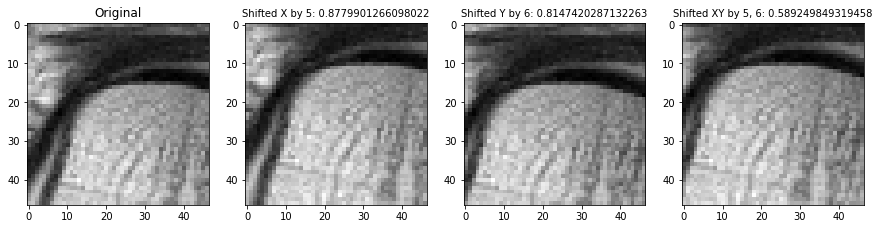

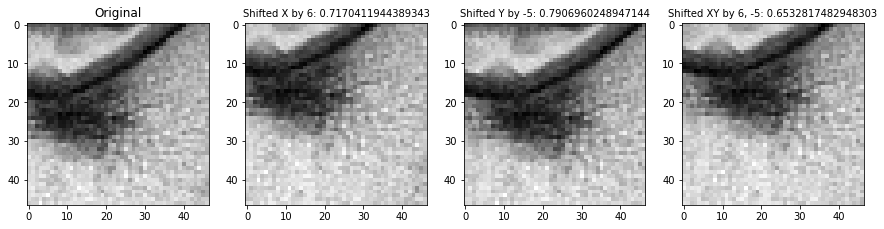

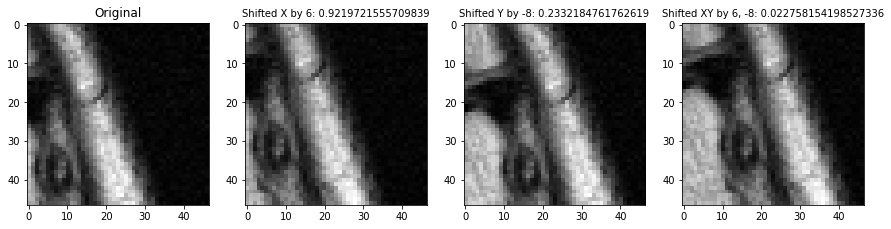

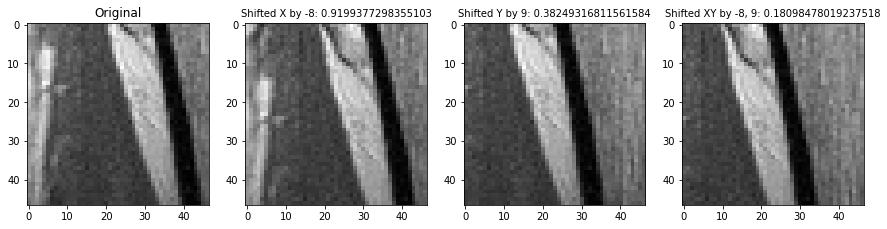

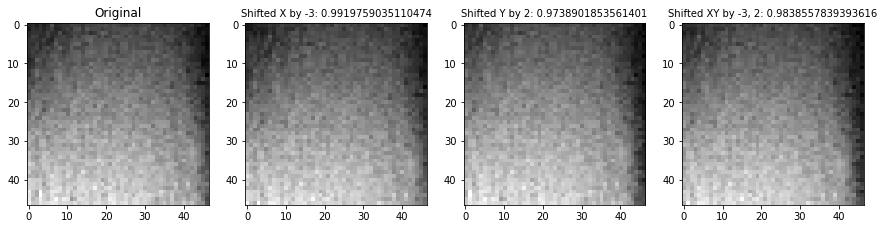

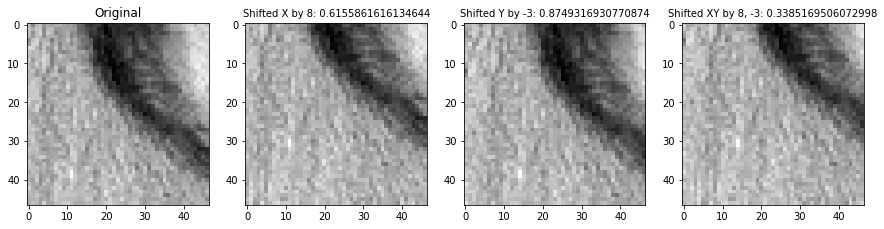

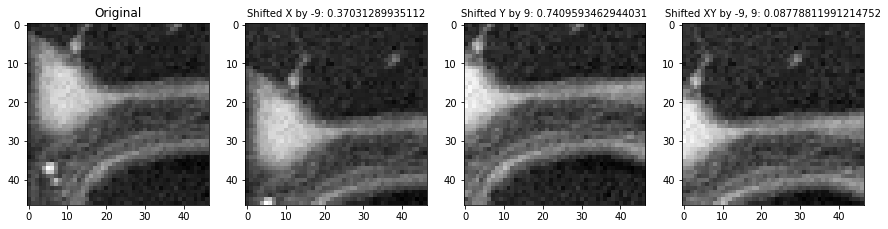

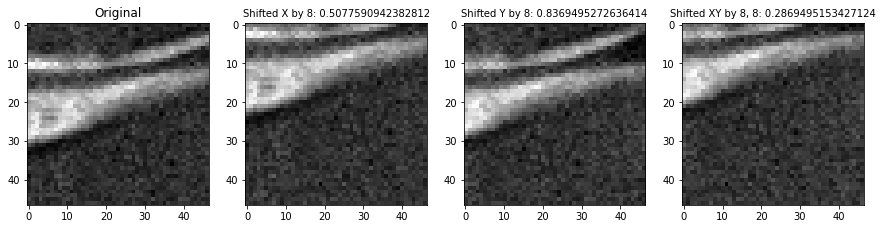

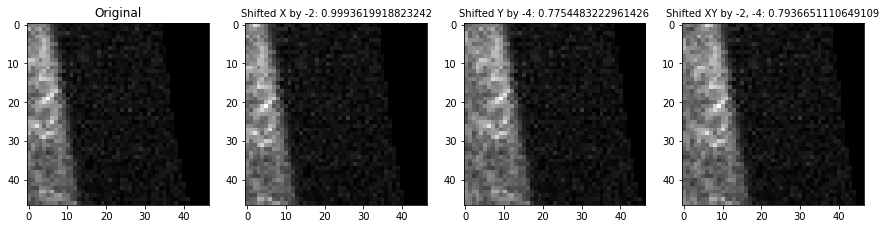

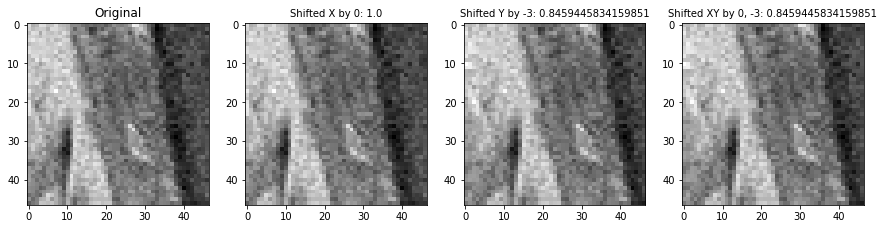

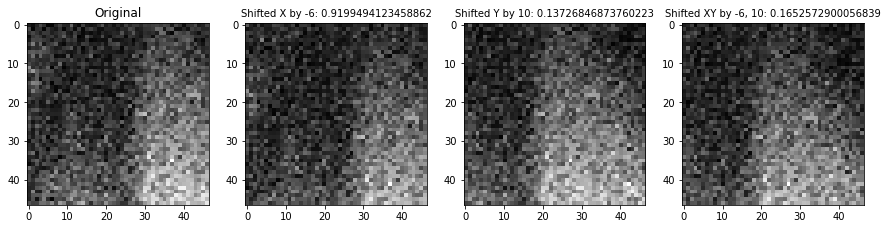

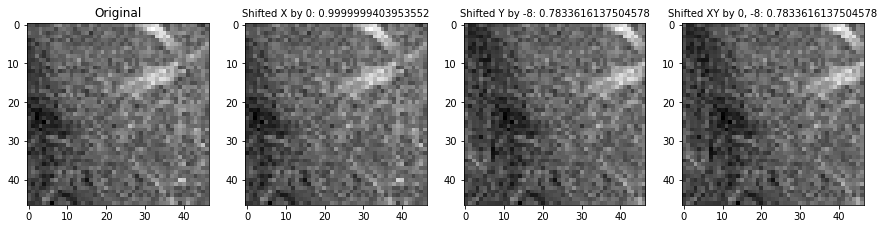

In [72]:
#Plot shifted image comparison
for i, three in enumerate(shifted_patches):
    shifted_x, shifted_y, shifted_xy, x, y = three

    #get embedding and score
    shiftx_emb = ksnet(shifted_x.to(device))[0]
    shifty_emb = ksnet(shifted_y.to(device))[0]
    shiftxy_emb = ksnet(shifted_xy.to(device))[0]
    
    shiftx_score = torch.sum(patch_embs[i] * shiftx_emb, dim=1).detach().cpu().mean()
    shifty_score = torch.sum(patch_embs[i] * shifty_emb, dim=1).detach().cpu().mean()
    shiftxy_score = torch.sum(patch_embs[i] * shiftxy_emb, dim=1).detach().cpu().mean()
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1,4,1)
    plt.imshow(patches[i][0, 0], cmap='gray')
    plt.title("Original")
    plt.subplot(1,4,2)
    plt.imshow(shifted_x[0, 0], cmap='gray')
    plt.title(f"Shifted X by {x}: {shiftx_score}", fontdict = {'fontsize' : 10})
    plt.subplot(1,4,3)
    plt.imshow(shifted_y[0, 0], cmap='gray')
    plt.title(f"Shifted Y by {y}: {shifty_score}", fontdict = {'fontsize' : 10})
    plt.subplot(1,4,4)
    plt.imshow(shifted_xy[0, 0], cmap='gray')
    plt.title(f"Shifted XY by {x}, {y}: {shiftxy_score}", fontdict = {'fontsize' : 10})


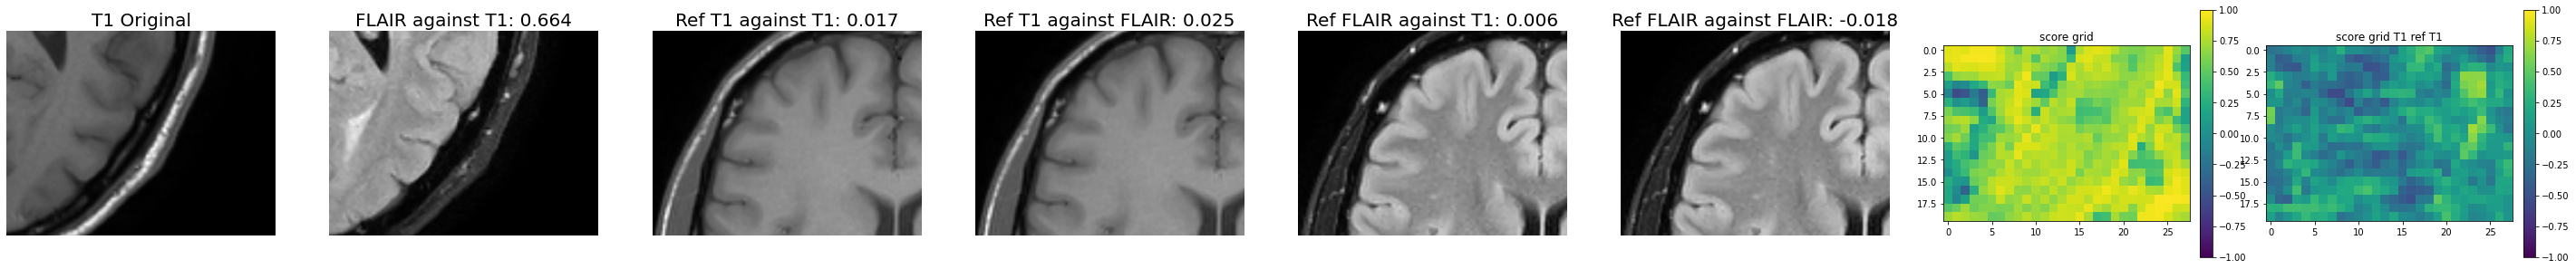

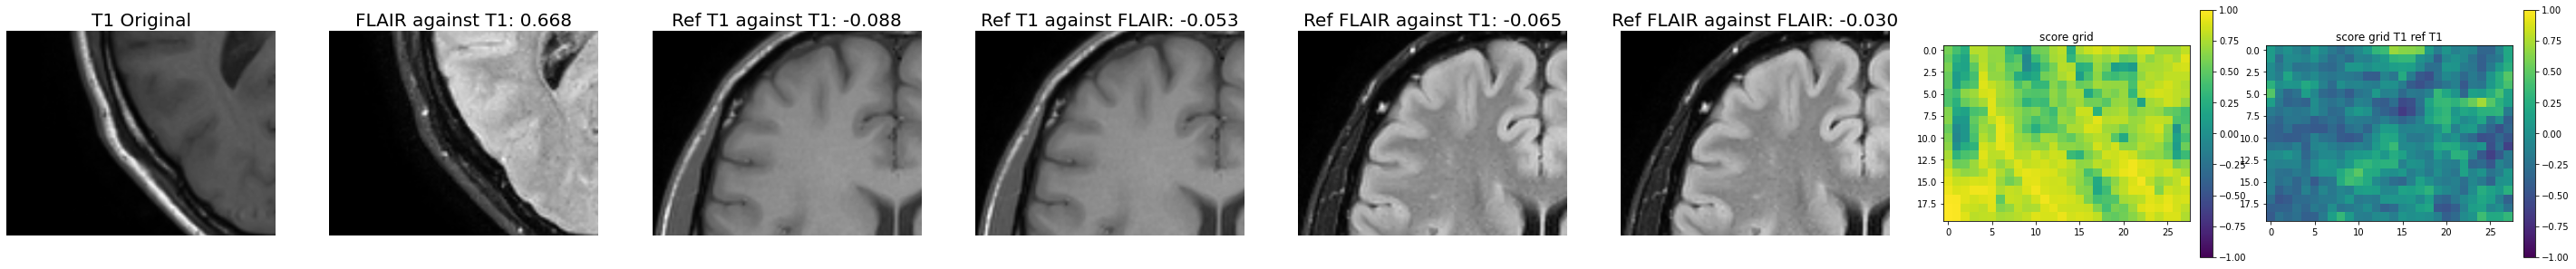

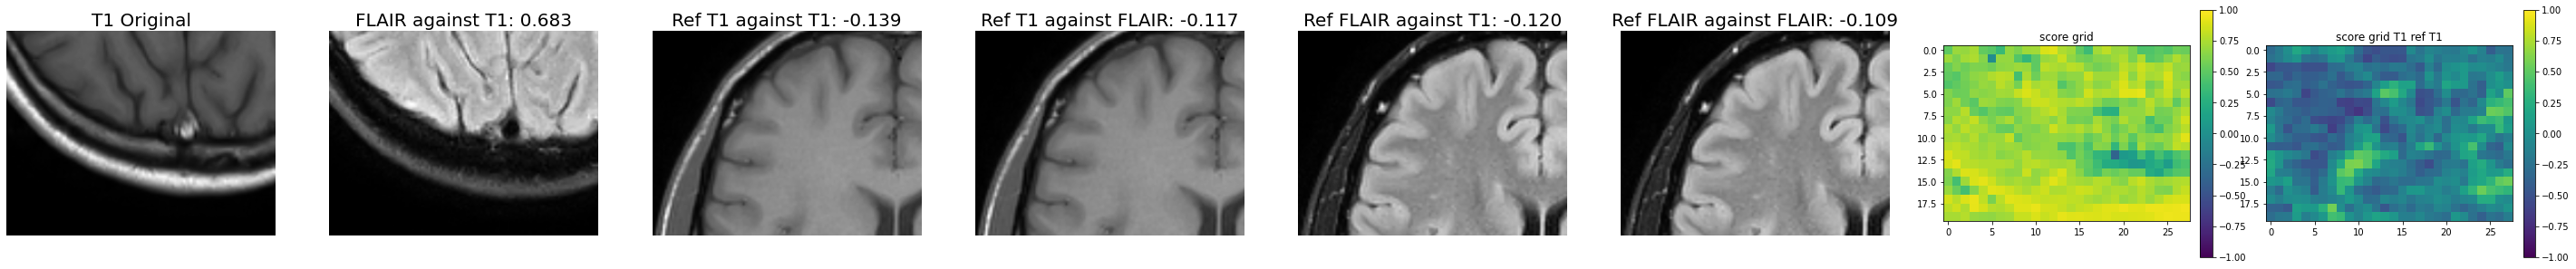

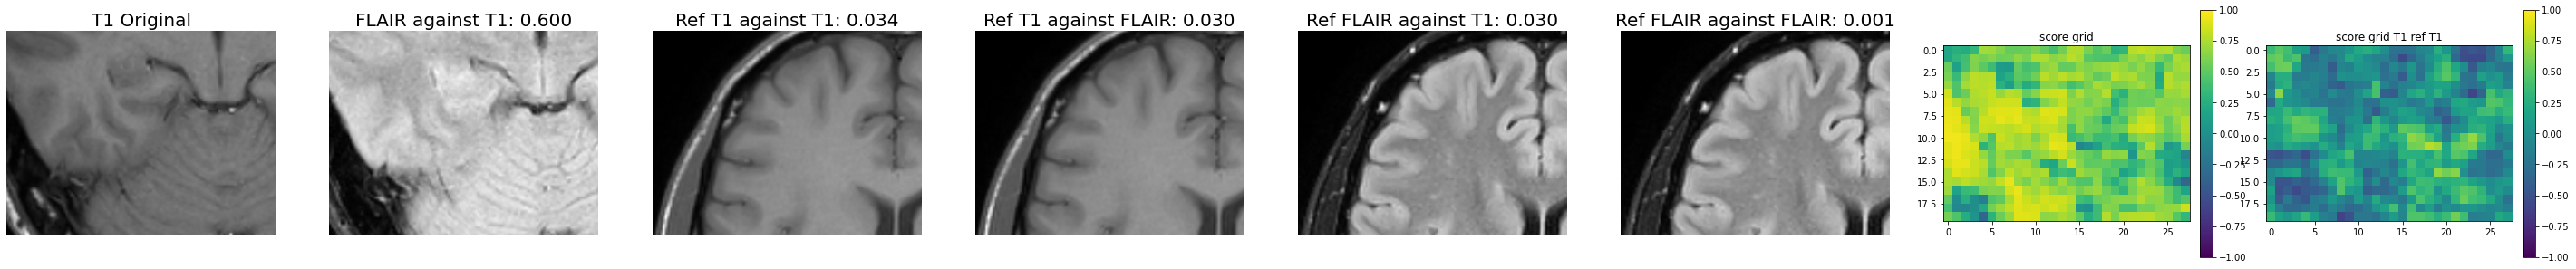

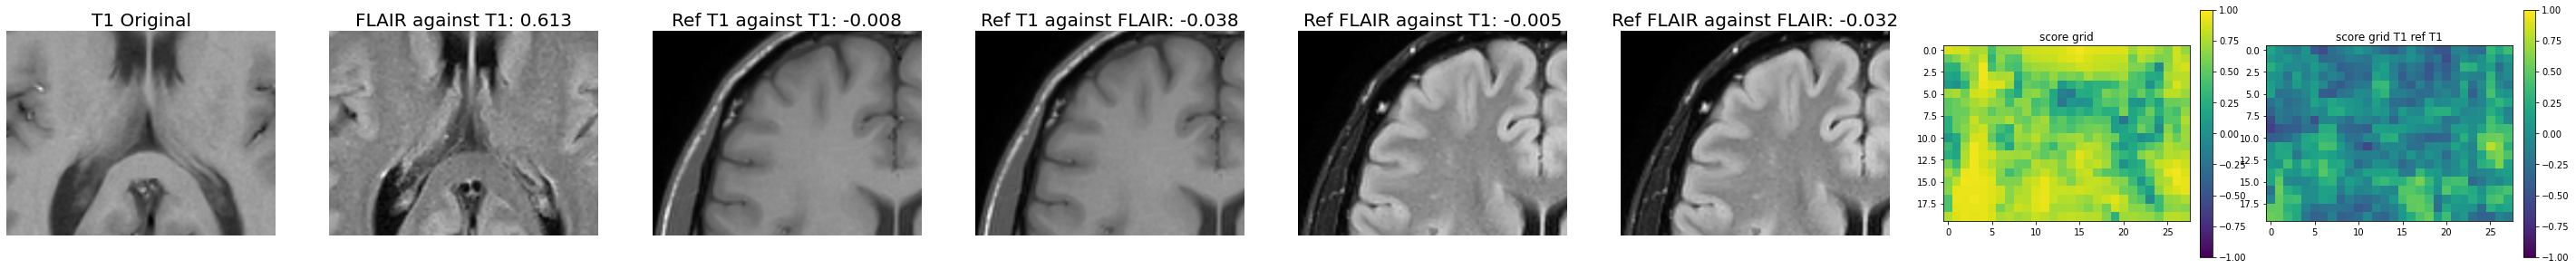

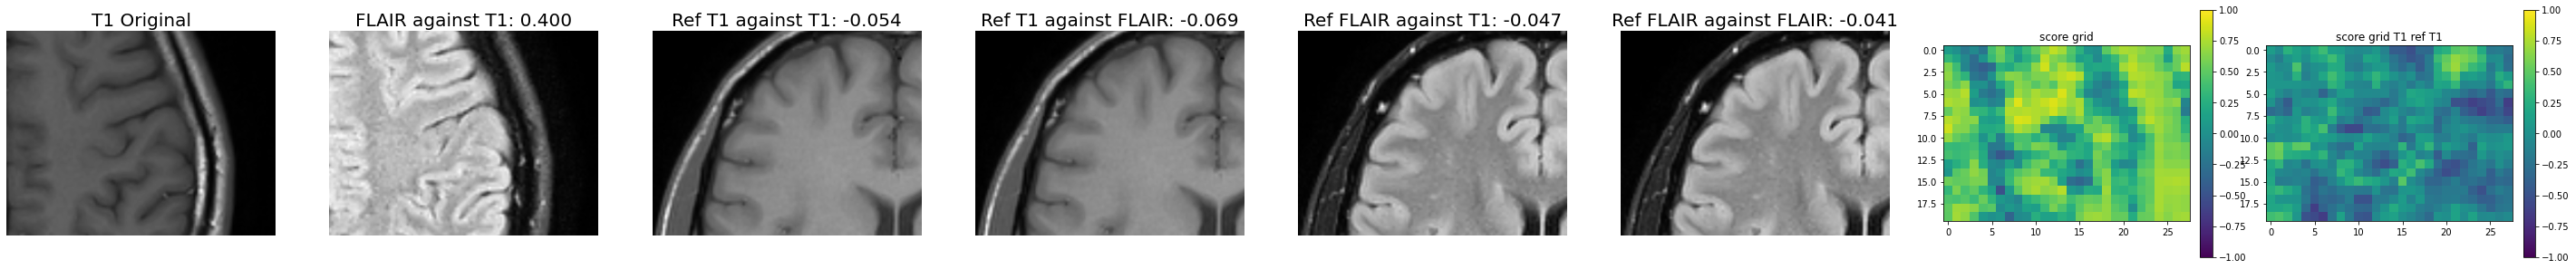

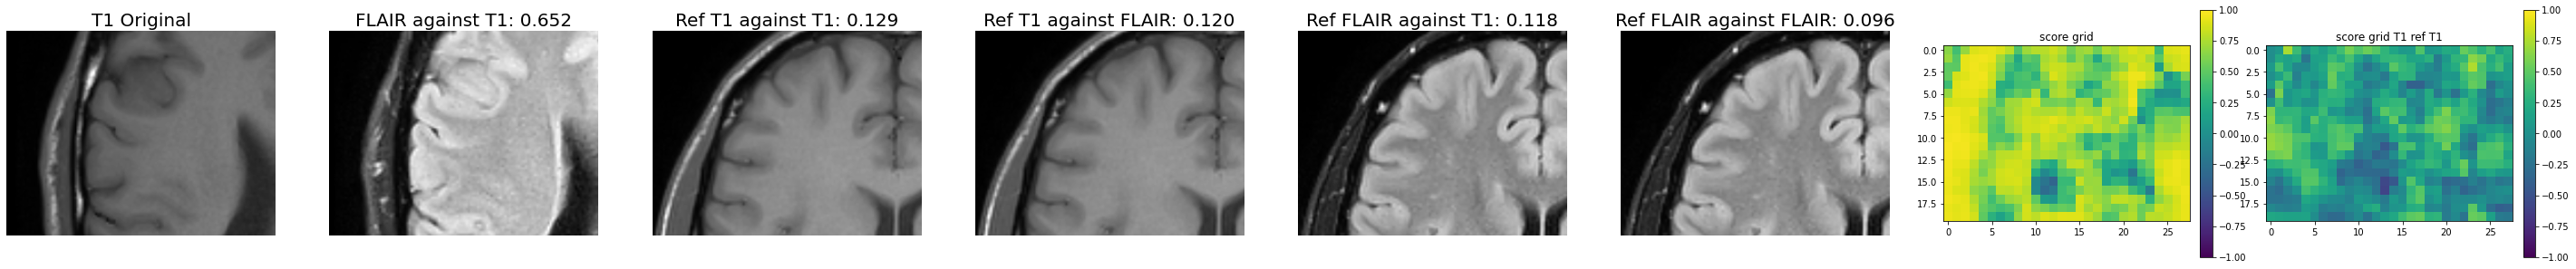

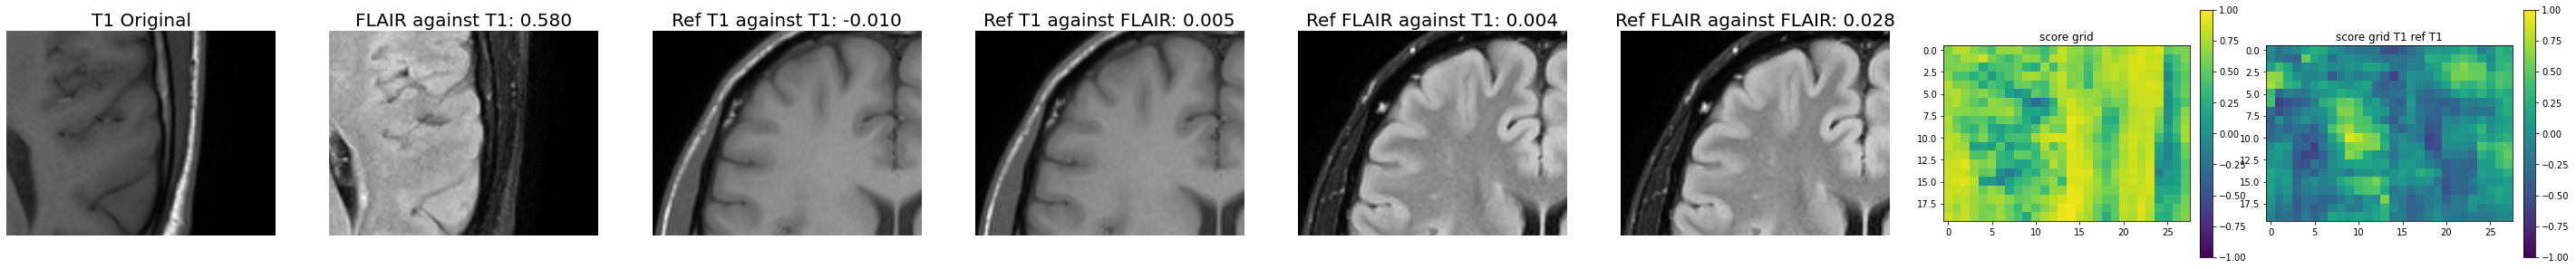

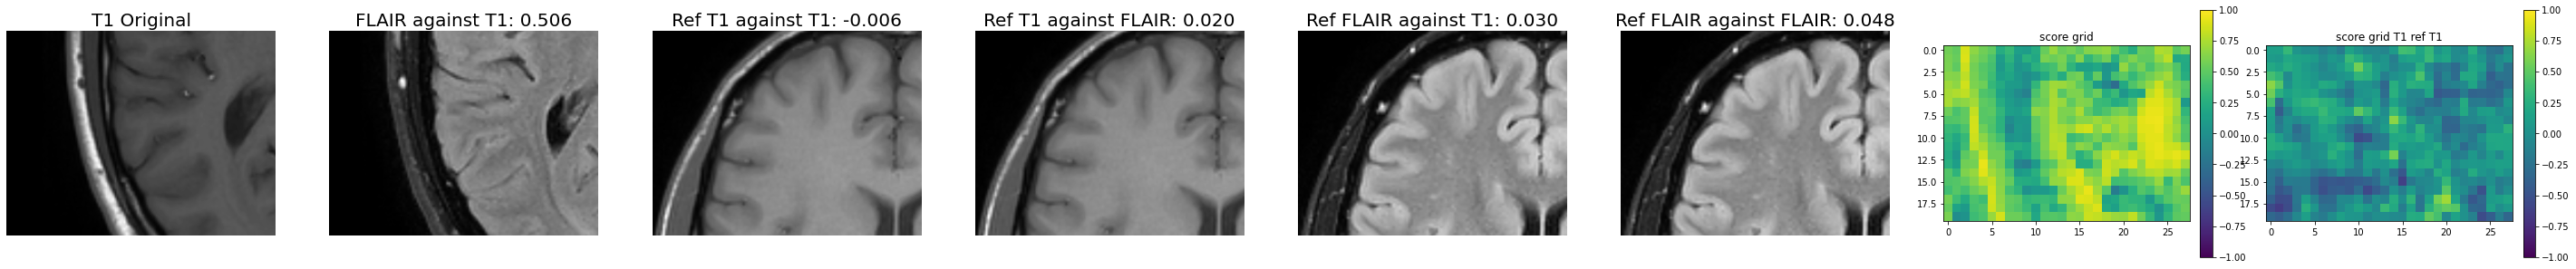

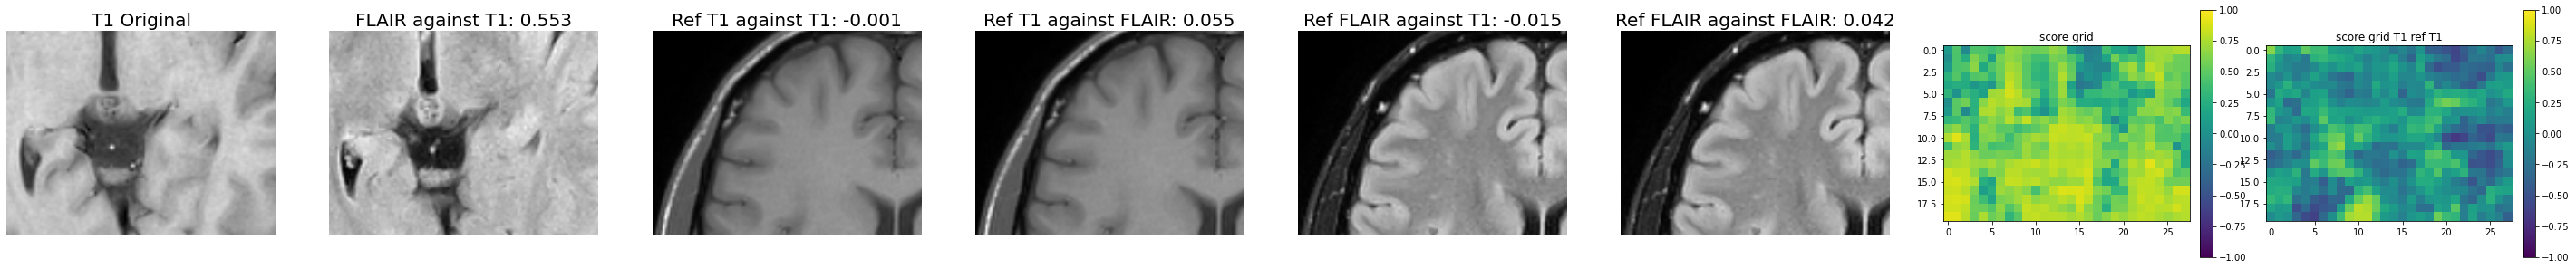

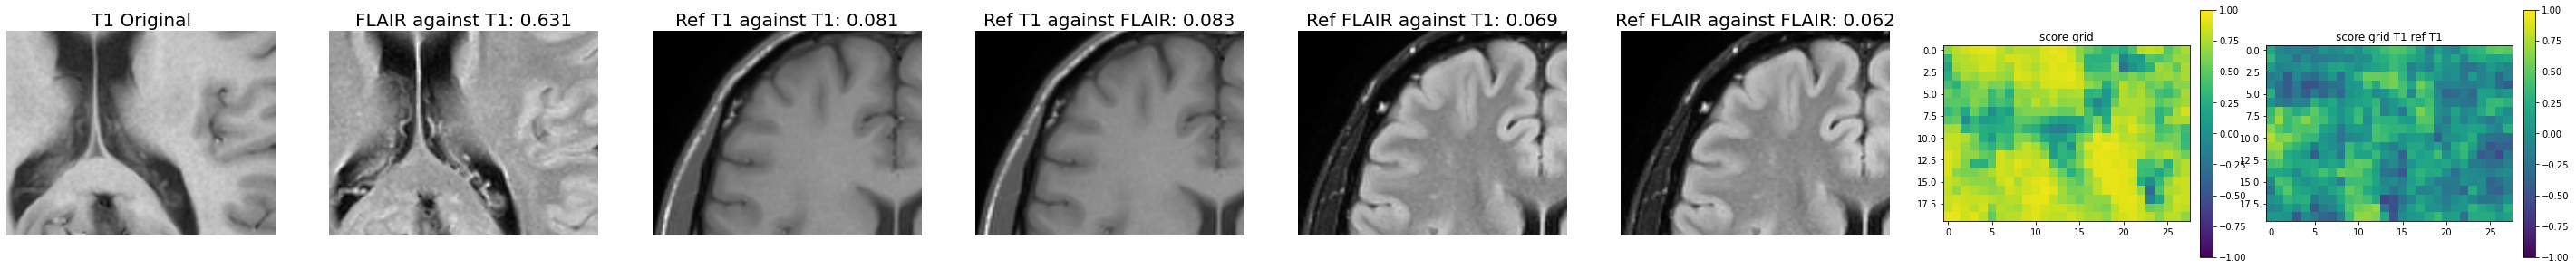

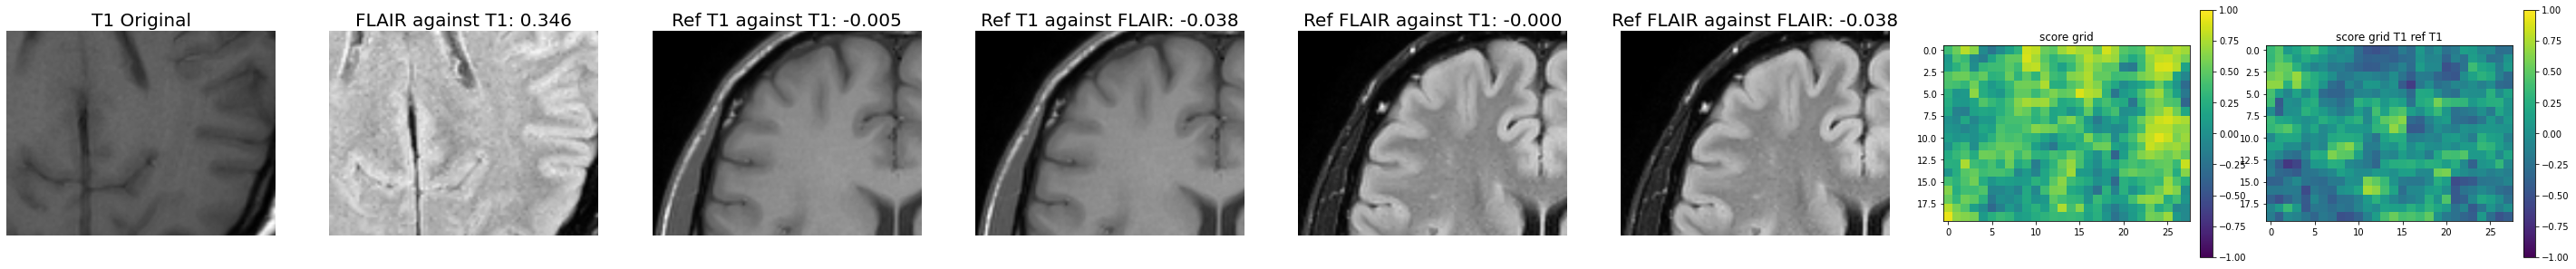

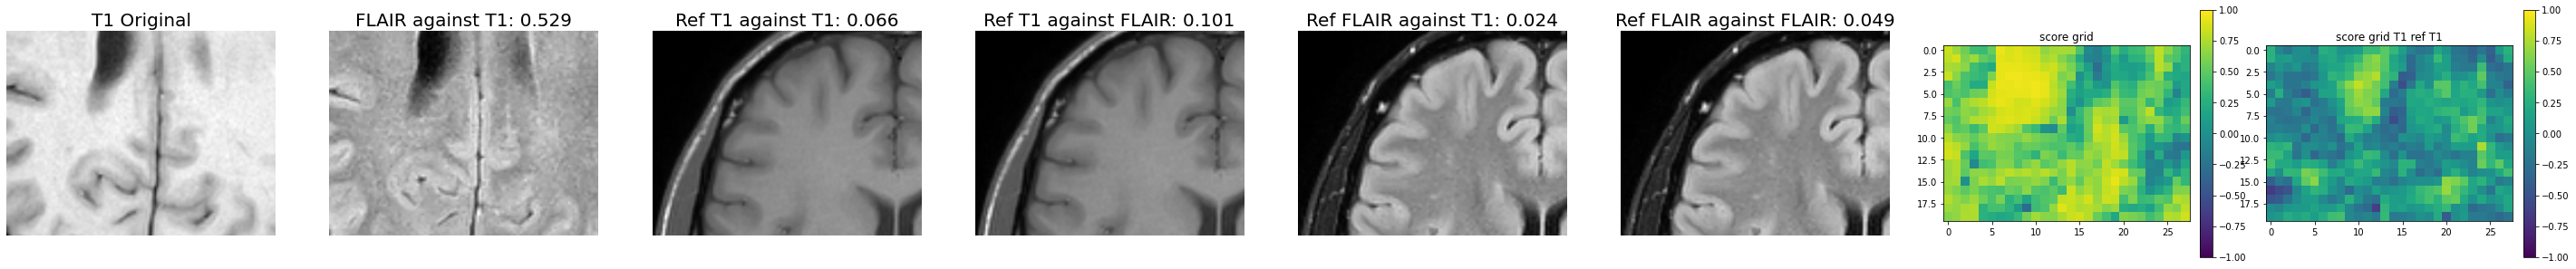

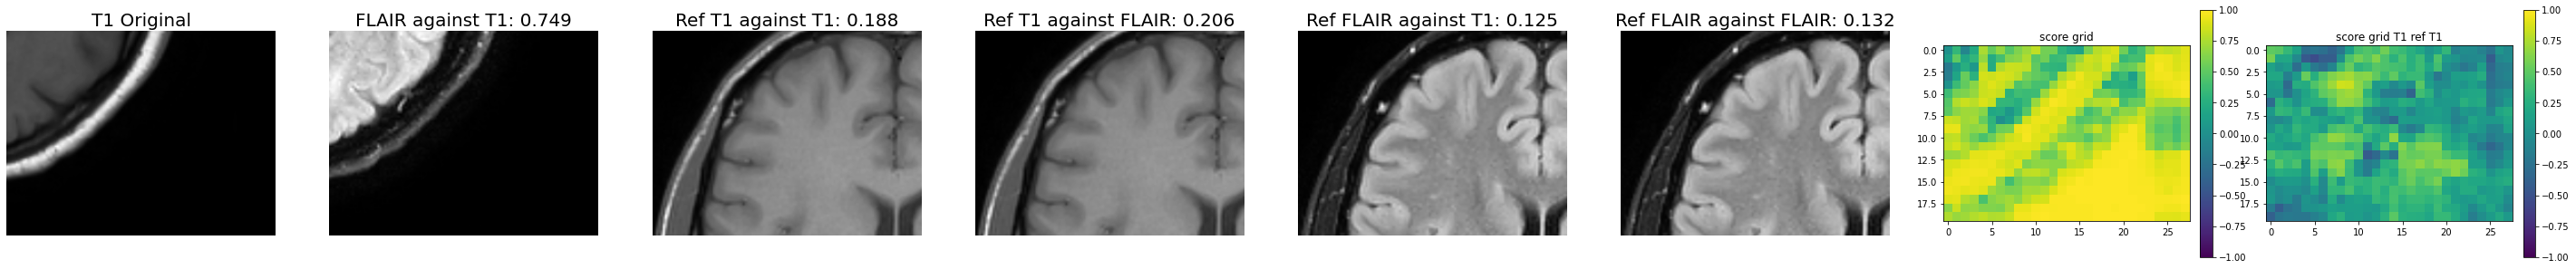

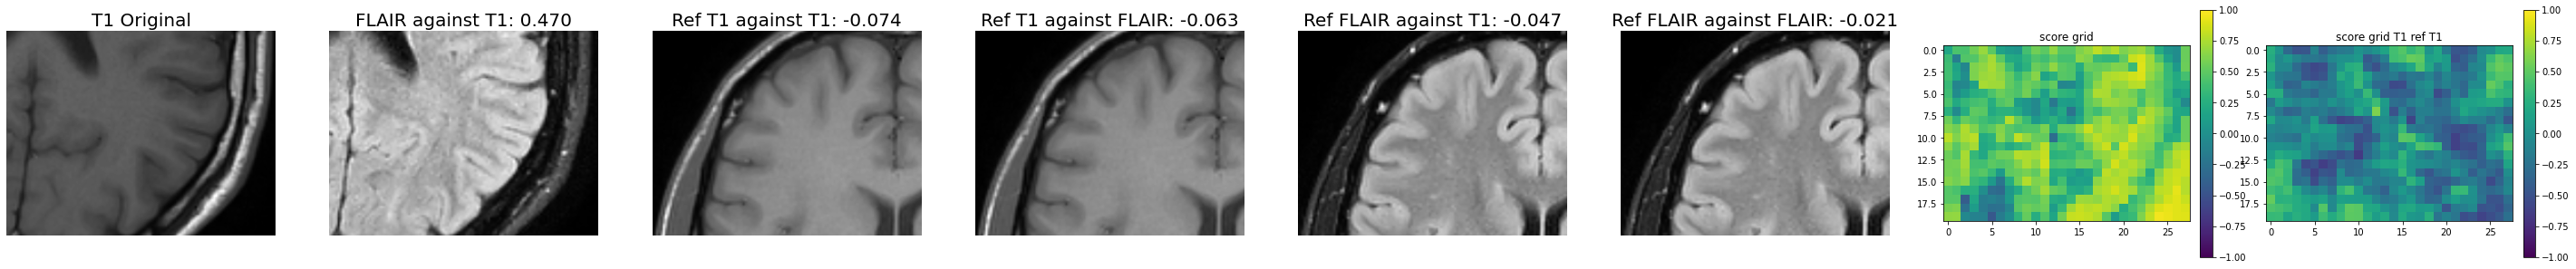

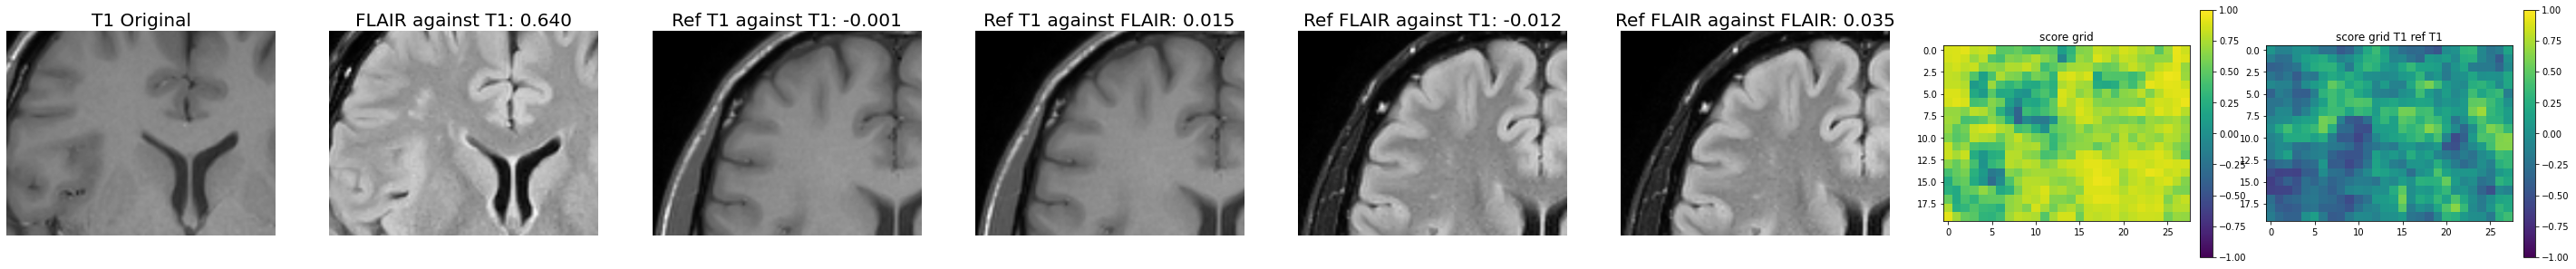

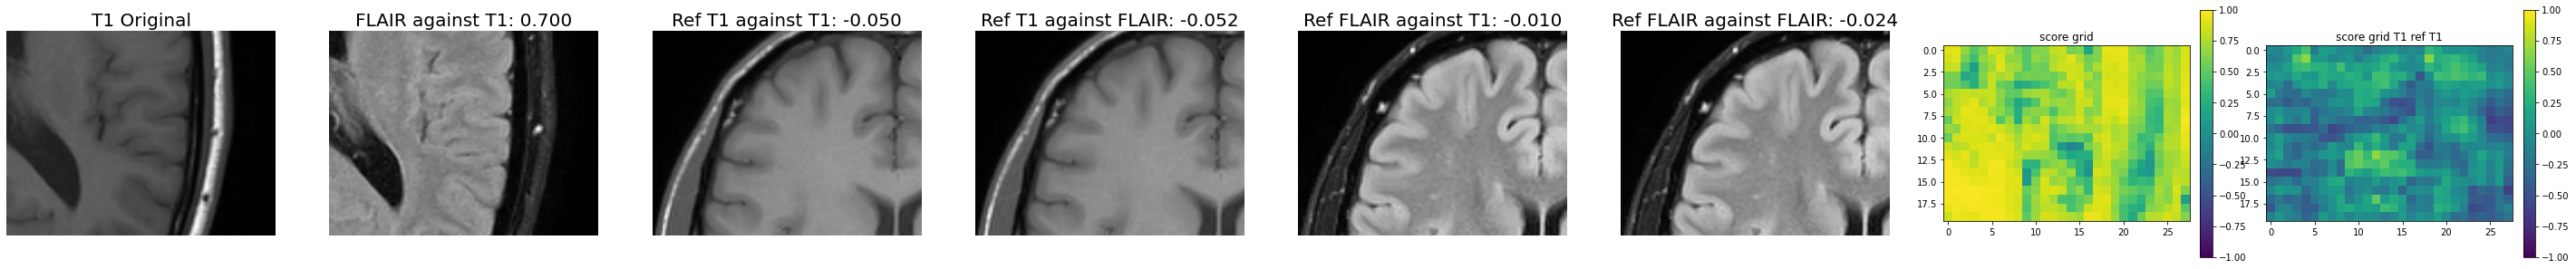

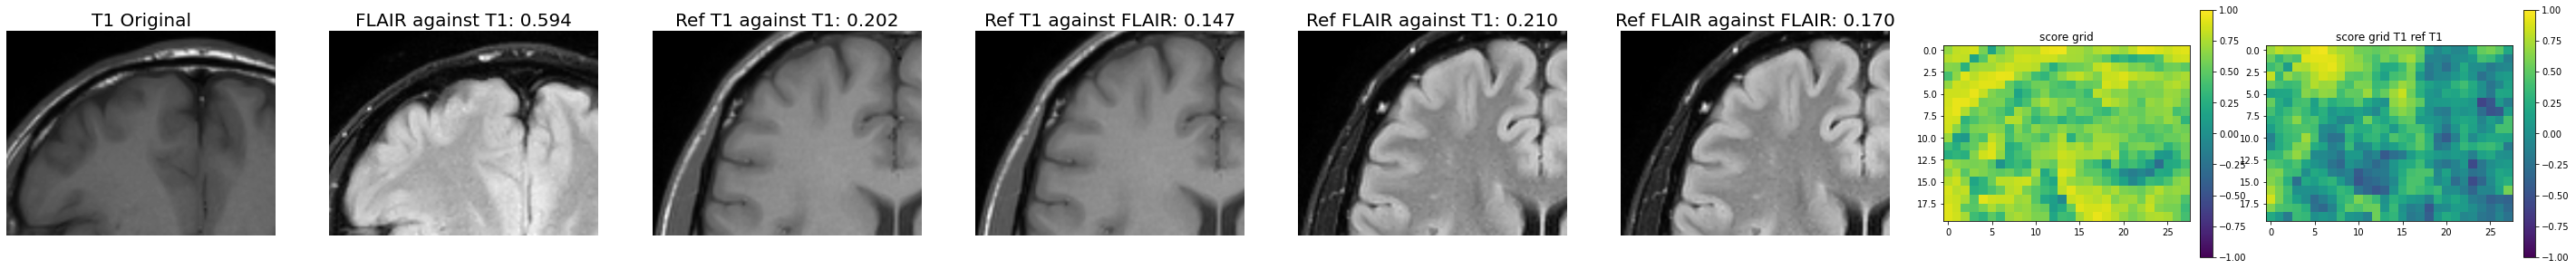

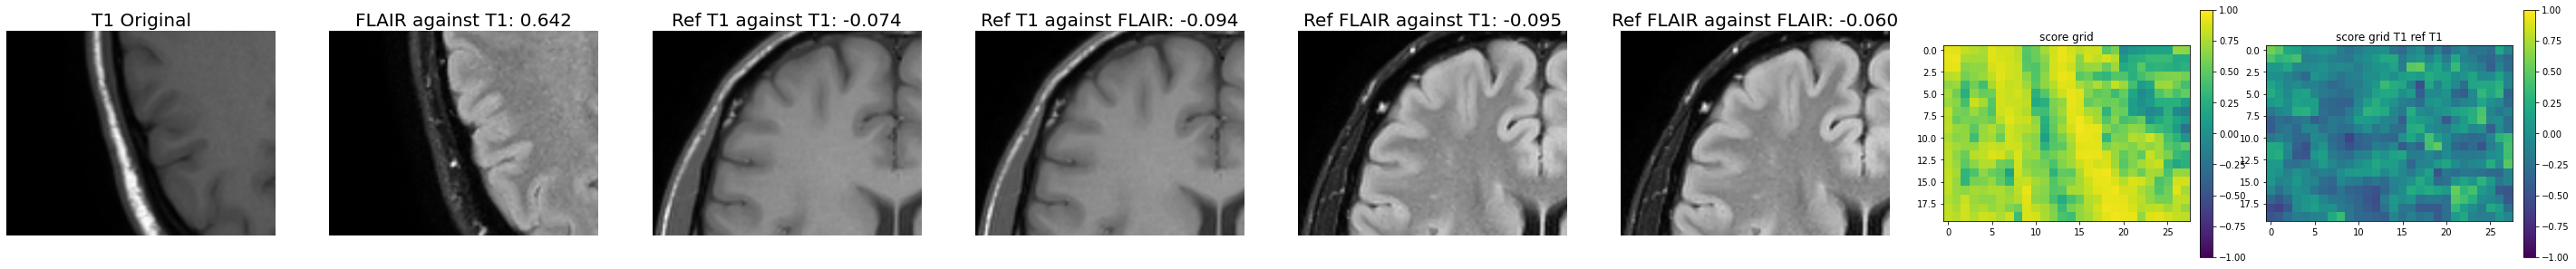

In [6]:
#Plot Real T1/T2 data
import torchvision 

def preprocess(file):
    filename = os.path.join(args.t1t2dir, file)
    original_t1 = np.array(h5py.File(filename)["T1"])
    original_t2 = np.array(h5py.File(filename)["FLAIR"])
#     original_t2 = np.array(h5py.File(filename)["T2"])
    imlist = [original_t1, original_t2]
    resizer =  torchvision.transforms.Resize((int(original_t1.shape[1] / 0.4375),
                                              int(original_t1.shape[2] / 0.4375)))
    
    offset = None
    for i in range(len(imlist)):
        img = torch.from_numpy(imlist[i])
        img = torch.abs(img).float()
        img = resizer(img)
        img = minmax_norm(img)
        img = normalize(img)
        img, offset = random_crop(img, offset=offset)
        imlist[i] = img[None]
    return imlist[0], imlist[1]

files = os.listdir(args.t1t2dir)

ref_t1, ref_t2 = preprocess(files[0])
ref_t1_emb = ksnet(ref_t1.to(device))[0]
ref_t2_emb = ksnet(ref_t2.to(device))[0]

for i, file in enumerate(files[1:20]):
    t1, t2 = preprocess(file)
   
    t1_emb = ksnet(t1.to(device))[0]
    t2_emb = ksnet(t2.to(device))[0]
    score = torch.sum(t1_emb * t2_emb, dim=1).detach().cpu().mean()# [0,0,0]
    
    score_grid = torch.sum(t1_emb * t2_emb, dim=1)
    t1_ref_t1_score = torch.sum(t1_emb * ref_t1_emb, dim=1).detach().cpu().mean()# [0,0,0]
    score_grid_t1_ref_t1 = torch.sum(t1_emb * ref_t1_emb, dim=1)
    t2_ref_t1_score = torch.sum(t2_emb * ref_t1_emb, dim=1).detach().cpu().mean() # [0,0,0]
    t1_ref_t2_score = torch.sum(t1_emb * ref_t2_emb, dim=1).detach().cpu().mean() # [0,0,0]
    t2_ref_t2_score = torch.sum(t2_emb * ref_t2_emb, dim=1).detach().cpu().mean() # [0,0,0]
    
    #TODO: resize and interpolate score grid to overlay over t1 image
    plt.figure(figsize = (50,50))
    plt.subplot(1,8,1)
    plt.imshow(t1[0, 0], cmap='gray')
#     plt.imshow(score_grid[0].cpu(), vmin=-1, vmax=1, alpha=0.01)
    plt.axis("off")
    plt.title(f"T1 Original", fontdict = {'fontsize' : 20})
    
    plt.subplot(1,8,2)
    plt.imshow(t2[0, 0], cmap='gray')
    plt.axis("off")
    plt.title(f"FLAIR against T1: {score:.3f}", fontdict = {'fontsize' : 20})
    
    plt.subplot(1,8,3)
    plt.imshow(ref_t1[0, 0], cmap='gray')
    plt.axis("off")
    plt.title(f"Ref T1 against T1: {t1_ref_t1_score:.3f}", fontdict = {'fontsize' : 20})
    
    plt.subplot(1,8,4)
    plt.imshow(ref_t1[0, 0], cmap='gray')
    plt.axis("off")
    plt.title(f"Ref T1 against FLAIR: {t2_ref_t1_score:.3f}", fontdict = {'fontsize' : 20})
    
    plt.subplot(1,8,5)
    plt.imshow(ref_t2[0, 0], cmap='gray')
    plt.axis("off")
    plt.title(f"Ref FLAIR against T1: {t1_ref_t2_score:.3f}", fontdict = {'fontsize' : 20})
    
    plt.subplot(1,8,6)
    plt.imshow(ref_t2[0, 0], cmap='gray')
    plt.axis("off")
    plt.title(f"Ref FLAIR against FLAIR: {t2_ref_t2_score:.3f}", fontdict = {'fontsize' : 20})
    
    plt.subplot(1,8,7)
    plt.imshow(score_grid[0].cpu(), vmin=-1, vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("score grid")
    
    plt.subplot(1,8,8)
    plt.imshow(score_grid_t1_ref_t1[0].cpu(), vmin=-1, vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("score grid T1 ref T1")
    


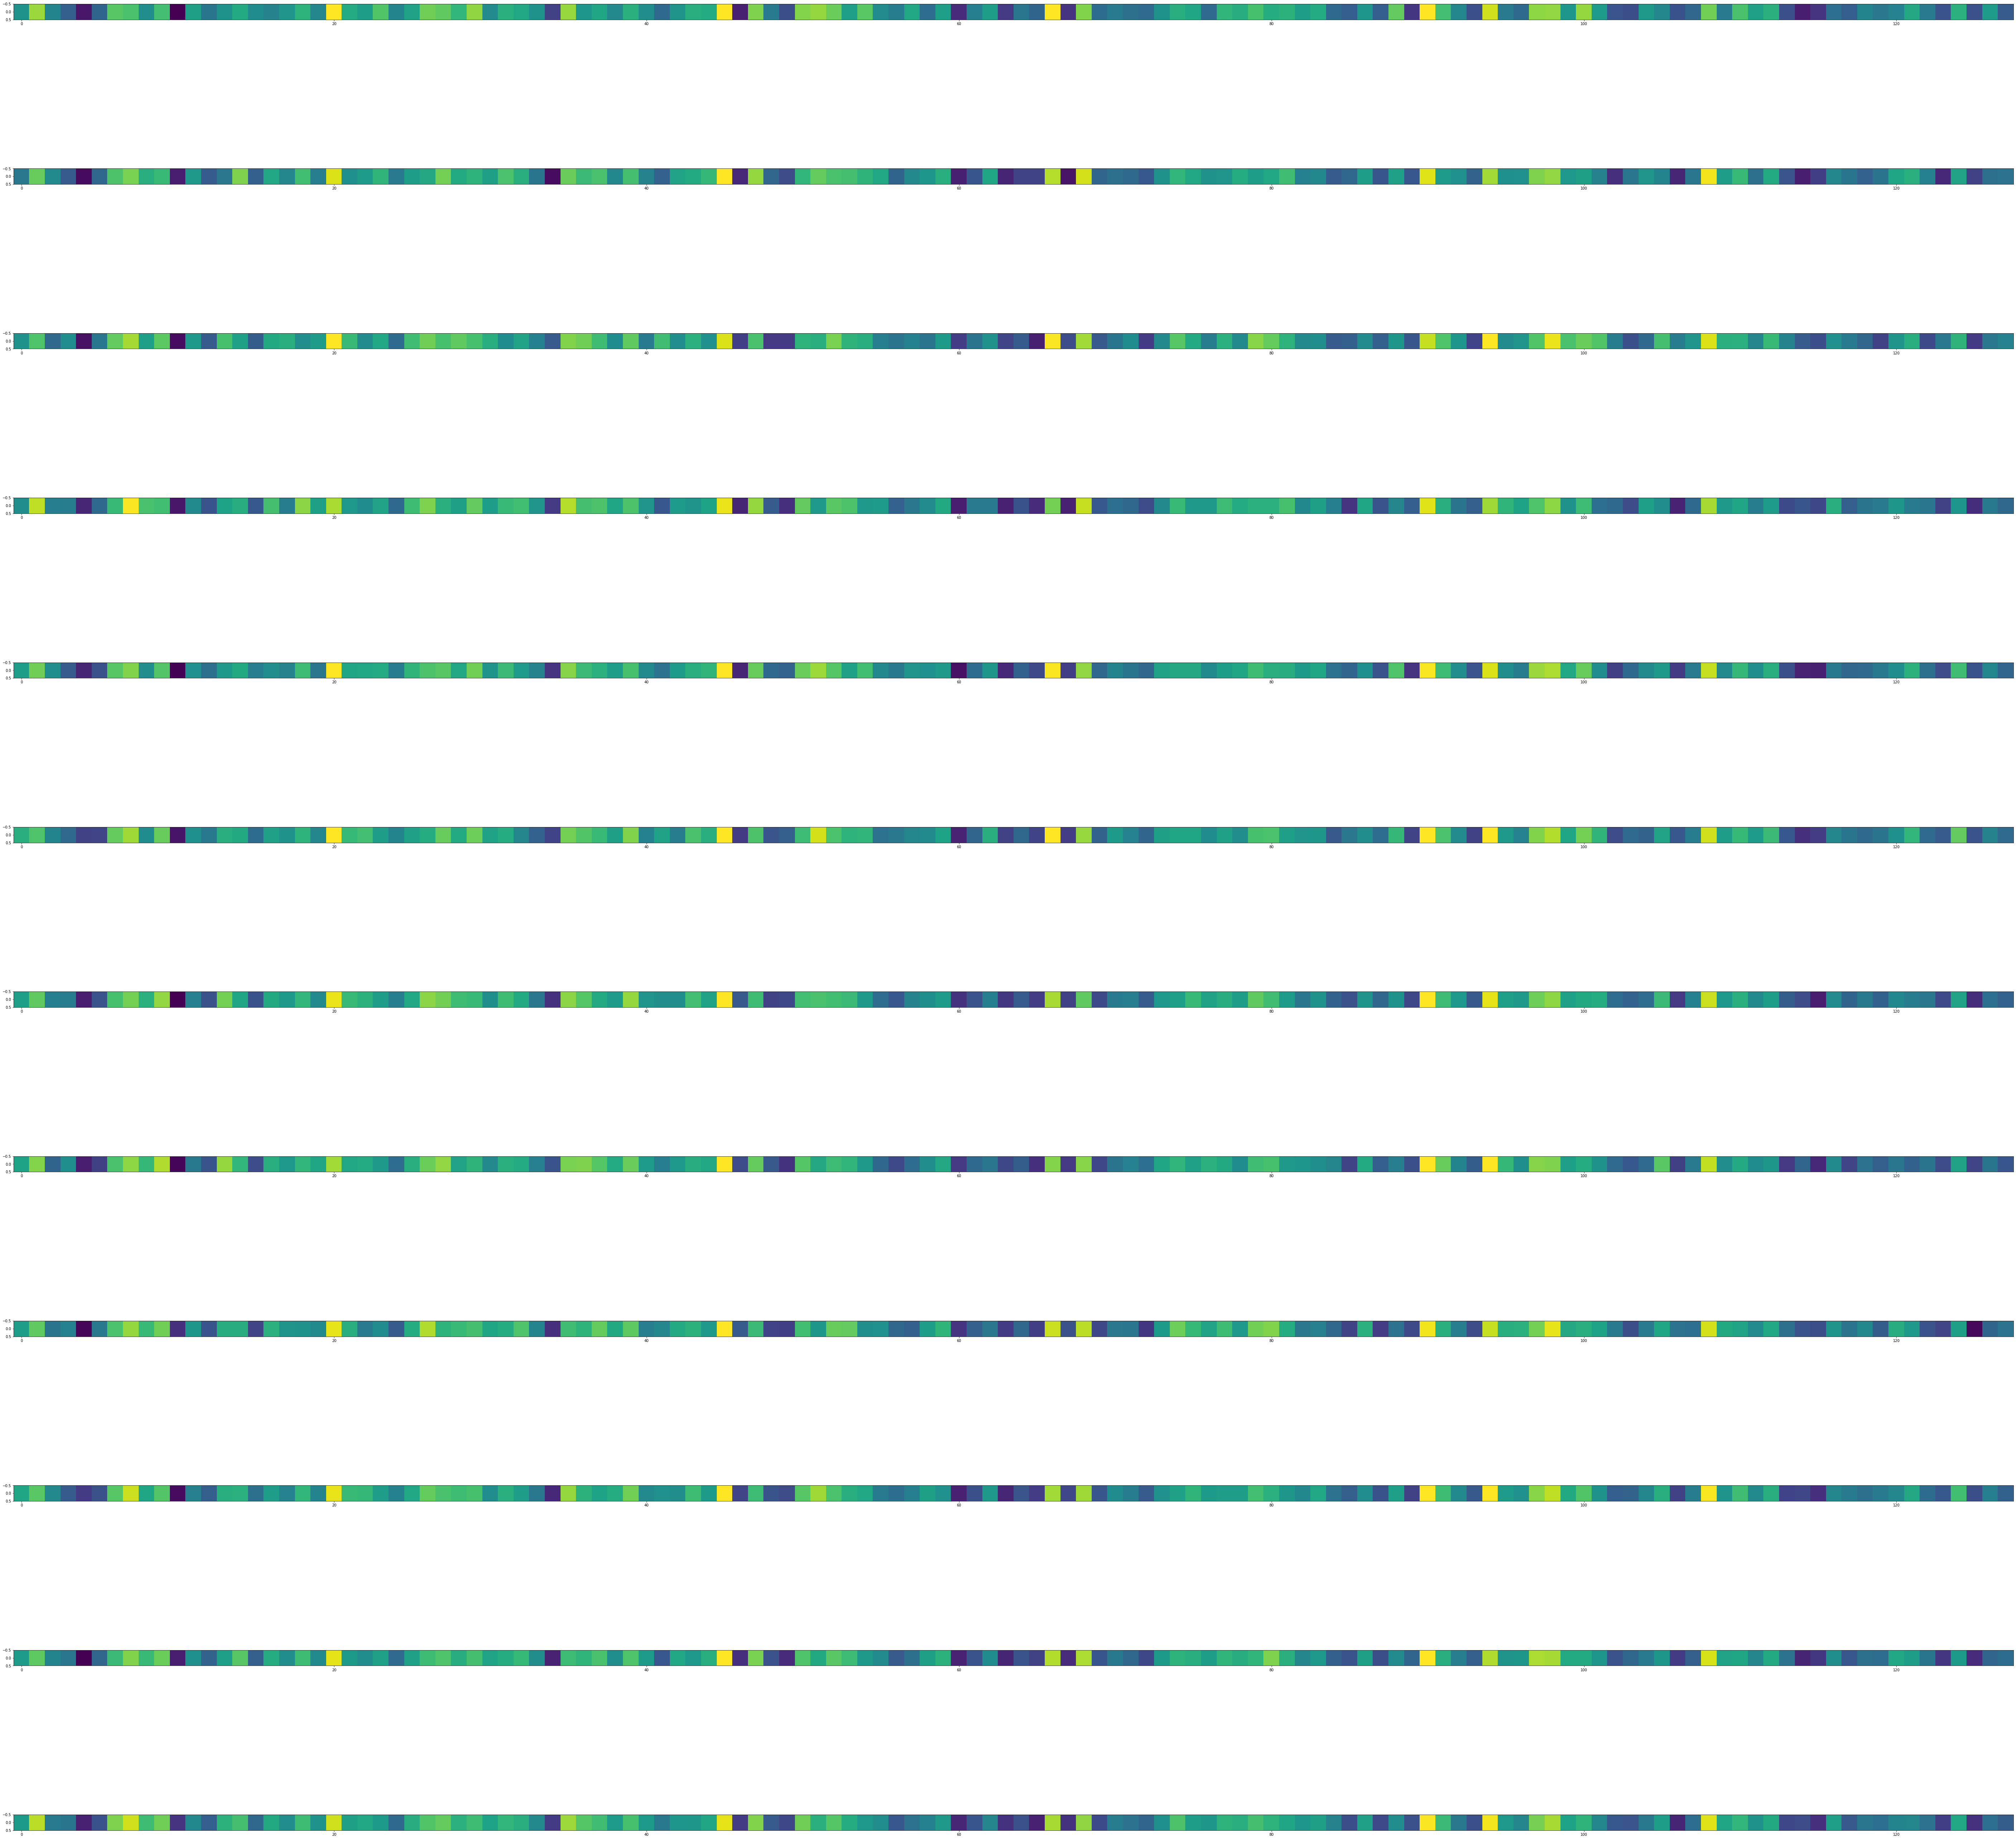

In [61]:
# Plot embeddings
fig_emb, ax_arr = plt.subplots(len(patch_embs), 1, figsize=(100, 100))
for i, emb in enumerate(patch_embs):
    ax_arr[i].imshow(emb.detach().cpu()[:, :, 0, 0], vmin=-0.2, vmax=0.2)

In [193]:
#Save Figures into 1 pdf
import os
from matplotlib.backends.backend_pdf import PdfPages

def save_multi_image(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()[-1:]
    print(fig_nums)
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

filename = os.path.join(save_dir, f"new_visualizations.pdf")
if os.path.isfile(filename):
    os.remove(filename)
save_multi_image(filename)

[23]
